# A first TEBD Example

Like `examples/c_tebd.py`, this notebook shows the basic interface for TEBD.
It initalized the transverse field Ising model $H = J XX + g Z$ at the critical point $J=g=1$,
and an MPS in the all-up state $|\uparrow\cdots \uparrow\rangle$.
It then performs a real-time evolution with TEBD and measures a few observables.
This setup correspond to a global quench from $g =\infty$ to $g=1$.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import tebd
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain

In [3]:
L = 30

In [4]:
model_params = {
    'J': 1. , 'g': 1.,  # critical
    'L': L,
    'bc_MPS': 'finite',    
}

M = TFIChain(model_params)

Reading 'bc_MPS'='finite' for config TFIChain
Reading 'L'=30 for config TFIChain
Reading 'J'=1.0 for config TFIChain
Reading 'g'=1.0 for config TFIChain


In [5]:
psi = MPS.from_lat_product_state(M.lat, [['up']])

In [6]:
tebd_params = {
    'N_steps': 1,
    'dt': 0.1,
    'order': 4,
    'trunc_params': {'chi_max': 100, 'svd_min': 1.e-12}
}
eng = tebd.Engine(psi, M, tebd_params)

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TEBD


In [7]:
def measurement(eng, data):
    keys = ['t', 'entropy', 'Sx', 'Sz', 'corr_XX', 'corr_ZZ', 'trunc_err']
    if data is None:
        data = dict([(k, []) for k in keys])
    data['t'].append(eng.evolved_time)
    data['entropy'].append(eng.psi.entanglement_entropy())
    data['Sx'].append(eng.psi.expectation_value('Sigmax'))
    data['Sz'].append(eng.psi.expectation_value('Sigmaz'))
    data['corr_XX'].append(eng.psi.correlation_function('Sigmax', 'Sigmax'))
    data['trunc_err'].append(eng.trunc_err.eps)
    return data

In [8]:
data = measurement(eng, None)

In [9]:
while eng.evolved_time < 5.:
    eng.run()
    measurement(eng, data)

Reading 'dt'=0.1 for config TEBD
Reading 'N_steps'=1 for config TEBD
Reading 'order'=4 for config TEBD
Calculate U for  {'order': 4, 'delta_t': 0.1, 'type_evo': 'real', 'E_offset': None, 'tau': 0.1}
--> time=0.100, max_chi=6, Delta_S=5.5243e-02, S=0.0552432967, since last update: 0.5 s
--> time=0.200, max_chi=6, Delta_S=1.0453e-01, S=0.1597705686, since last update: 0.4 s
--> time=0.300, max_chi=8, Delta_S=1.1368e-01, S=0.2734471407, since last update: 0.5 s
--> time=0.400, max_chi=10, Delta_S=1.0226e-01, S=0.3757082127, since last update: 0.4 s
--> time=0.500, max_chi=12, Delta_S=8.2474e-02, S=0.4581821173, since last update: 0.4 s
--> time=0.600, max_chi=12, Delta_S=6.3393e-02, S=0.5215746922, since last update: 0.5 s
--> time=0.700, max_chi=15, Delta_S=5.0837e-02, S=0.5724119006, since last update: 0.5 s
--> time=0.800, max_chi=18, Delta_S=4.7046e-02, S=0.6194580889, since last update: 0.5 s
--> time=0.900, max_chi=20, Delta_S=5.0606e-02, S=0.6700636890, since last update: 0.5 s
-->

Text(0, 0.5, 'entropy $S$')

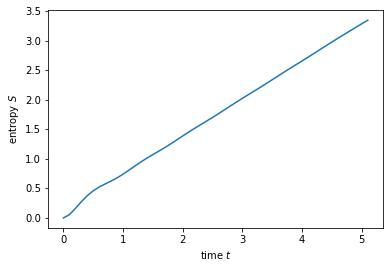

In [10]:
plt.plot(data['t'], np.array(data['entropy'])[:, L//2])
plt.xlabel('time $t$')
plt.ylabel('entropy $S$')

The growth of $S$ linear in time is typical for a global quench and to be expected from the quasi-particle picture

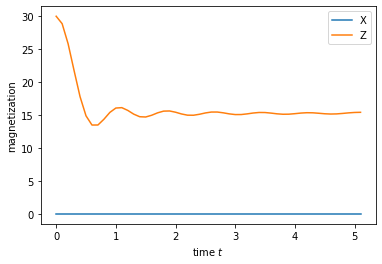

In [11]:
plt.plot(data['t'], np.sum(data['Sx'], axis=1), label="X")
plt.plot(data['t'], np.sum(data['Sz'], axis=1), label="Z")

plt.xlabel('time $t$')
plt.ylabel('magnetization')
plt.legend(loc='best')

The strict conservation of `X` being zero is ensured by charge conservation, because `X` changes the parity sector.

Nevertheless, the `XX` correlation function can be nontrivial:


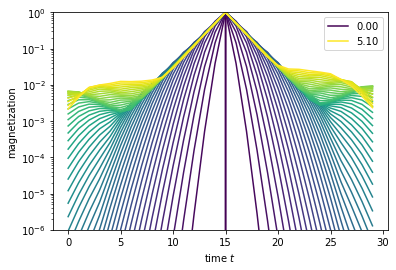

In [12]:
corrs = np.array(data['corr_XX'])
tmax = data['t'][-1]
x = np.arange(L)
cmap = matplotlib.cm.viridis
for i, t in list(enumerate(data['t'])):
    if i == 0 or i == len(data['t']) - 1:
        label = '{t:.2f}'.format(t=t)
    else:
        label = None
    plt.plot(x, corrs[i, L//2, :], color=cmap(t/tmax), label=label)

plt.xlabel('time $t$')
plt.ylabel('magnetization')
plt.yscale('log')
plt.ylim(1.e-6, 1.)
plt.legend()

The output of the run showed that we gradually increased the bond dimension and only reached the maximum chi around $t=2.5$. At this point we start to truncate significantly, because we cut off the tail whatever the singular values are. This is clearly visible if we plot the truncation error vs. time. Note the log-scale, though: if you are fine with an error of say 1 permille for expectation values, you can still go on for a bit more!

Text(0, 0.5, 'truncation error')

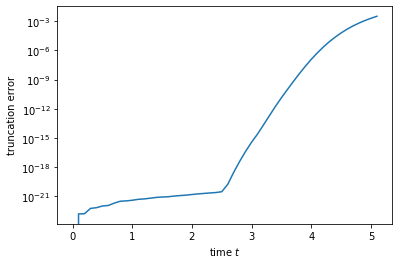

In [17]:
plt.plot(data['t'], data['trunc_err'])

plt.yscale('log')
#plt.ylim(1.e-15, 1.)
plt.xlabel('time $t$')
plt.ylabel('truncation error')